In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import cv2
import torch
import pickle
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import ParameterGrid

In [2]:
import os
from PIL import Image
import imagehash
from tqdm.auto import tqdm

df1 = pd.read_feather('../input/pet-data/df1_train_test_all_4ndplace.ftr')

df2 = pd.read_csv('../input/pet-data/df2.csv')

In [3]:
df1.T

,0,1,2,3,4,5,6,7,8,9,...,72766,72767,72768,72769,72770,72771,72772,72773,72774,72775
PetID,d336e6953,77544cbd4,0149d04e7,cad25c91b,9c7476c25,e01f077a7,449290a8b,6c9382d17,ebdf19959,6a864757b,...,af7305535,f51767bbe,c46f3bb03,ef20ce351,8a69b8ca9,819610fb0,280dd2698,4b393cb28,b88cb23c9,311368756
AdoptionSpeed,1.0,1.0,2.0,3.0,1.0,4.0,3.0,2.0,4.0,3.0,...,4.0,1.0,3.0,2.0,2.0,1.0,1.0,4.0,4.0,4.0
hash,193f20c0c86c2f2f,0f0f0f3fffffe000,387fef070743071f,0c00003f27e7ffff,ffb301d9f0e08e04,1f1f40602c1e9f9f,ffc7c3c7c3c3d3a7,fff860000083feff,18981c371fff0707,f0fcece060302040,...,0078784cecfdffff,78787c1c18797b38,0261f03cbaf1e87c,0f0f79f1f0f8f8b8,00000c1d9f8fffff,00003e3f3f1f0000,00001c1e6e7f767c,3070380cfbffffff,f000faffe7c3c111,78cf3c0d08e0e0fd
act_0,0.366009,-0.593657,1.251785,0.16297,3.092722,2.920932,-0.696114,-0.49281,1.706766,1.803038,...,0.199261,-0.885382,1.37973,0.947242,-0.959748,-0.698598,-0.812514,1.13003,1.234119,-0.826506
act_1,1.569412,0.967155,-0.923897,0.111465,-0.049718,0.829643,0.919083,1.161602,2.647446,1.733478,...,-0.926048,0.721542,2.065623,1.796154,-0.622309,0.059438,1.578297,-0.719376,6.271873,-0.806469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Color1_label,0,6,0,1,1,6,0,1,4,4,...,6,3,4,0,0,6,1,2,0,1
Color2_label,1,0,1,3,0,0,6,5,6,0,...,0,6,0,1,1,0,4,6,1,2
Color3_label,1,0,5,0,0,0,0,5,0,0,...,0,0,0,5,5,0,4,0,0,4
no_name_label,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [4]:
df1.shape, df1.hash.nunique(), df2.hash.isin(df1.hash).sum()

((72776, 251), 70437, 1942)

In [5]:
#df1.to_csv('train_last_comp.csv', index=False)
df = pd.merge(df2, df1, how='left', on='hash')

In [6]:
df

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,...,Type_label,Dewormed_Vaccinated_label,Breed2_label,State_label,Gender_label,Color1_label,Color2_label,Color3_label,no_name_label,top_label_description_1_label
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,...,0.0,4.0,0.0,5.0,2.0,0.0,4.0,0.0,1.0,17.0
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,...,1.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,12.0
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,...,0.0,8.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,17.0
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10013,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10014,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10015,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10016,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,...,0.0,2.0,0.0,2.0,1.0,4.0,0.0,0.0,0.0,17.0


In [7]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,10008,10009,10010,10011,10012,10013,10014,10015,10016,10017
Id,0007de18844b0dbbb5e1f607da0606e0,0009c66b9439883ba2750fb825e1d7db,0013fd999caf9a3efe1352ca1b0d937e,0018df346ac9c1d8413cfcc888ca8246,001dc955e10590d3ca4673f034feeef2,001dd4f6fafb890610b1635f967ea081,0023b8a3abc93c712edd6120867deb53,0031d6a9ef7340f898c3e05f92c7bb04,0042bc5bada6d1cf8951f8f9f0d399fa,0049cb81313c94fa007286e9039af910,...,ff78a56d5e0029cd6288c62f7b7f10e5,ff903858a9899465ee4cd17e942bef24,ff9b3b3468c4b35a3b6450a1ddc88449,ffaf7bf7e64b9eecaf02fc2c14d6b654,ffb8b466494a3e48bcb874a2fe9b976d,ffbfa0383c34dc513c95560d6e1fdb57,ffcc8532d76436fc79e50eb2e5238e45,ffdf2e8673a1da6fb80342fa3b119a20,fff19e2ce11718548fa1c5d039a5192a,fff8e47c766799c9e12f3cb3d66ad228
Subject Focus,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Eyes,1,1,1,1,0,0,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1
Face,1,1,1,1,0,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1
Near,1,0,1,1,1,0,1,0,1,1,...,1,0,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Color1_label,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
Color2_label,4.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,...,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
Color3_label,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
no_name_label,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [8]:
df2.columns

Index(['Id', 'Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
       'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur', 'Pawpularity',
       'path', 'hash'],
      dtype='object')

In [9]:
df.columns

Index(['Id', 'Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
       'Group', 'Collage', 'Human',
       ...
       'Type_label', 'Dewormed_Vaccinated_label', 'Breed2_label',
       'State_label', 'Gender_label', 'Color1_label', 'Color2_label',
       'Color3_label', 'no_name_label', 'top_label_description_1_label'],
      dtype='object', length=266)

In [10]:
#df = pd.read_csv('../exps/exp1_swin_large_patch4_window12_384/train_cv_score.csv')
#df = pd.read_csv('ens_exp15.csv')

[0.5178882  0.16358161 0.32366979]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  from ipykernel import kernelapp as app


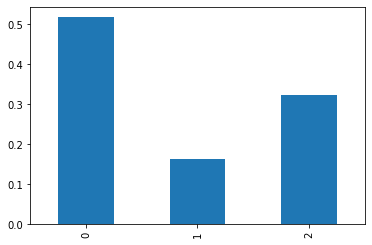

In [11]:
train = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')['Id'].map(lambda x:str(f'../input/petfinder-pawpularity-score/train/{x}.jpg'))
oof = pd.concat([train,
                 pd.read_csv('../input/petfinder-ensumble/exp085_ensumble/exp085_ensumble_oof.csv')['oof']], 
                 axis=1).set_index('Id')['oof']/100
oof2 = pd.concat([train,
                 pd.read_csv('../input/exp108/exp108_oof.csv')['pred']], 
                 axis=1).set_index('Id')['pred']/100


#df['pred4'] = df['path_x'].map(pd.read_csv('../input/pet-data/ens_exp15.csv', index_col='path')['pred'])
df['pred1'] = df['path'].map(pd.read_csv('../input/pet-data/ens_exp4-7-8-9-15.csv', index_col='path')['pred'])
df['pred2'] = df['path'].map(oof)
df['pred3'] = df['path'].map(oof2)

coef = np.linalg.lstsq(df[['pred1', 'pred2', 'pred3']], df['Pawpularity'] / 100)[0]
print(coef)
pd.Series(coef).plot(kind='bar')

df['pred'] = np.dot(df[['pred1', 'pred2', 'pred3']], coef)

In [12]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

df['fold'] = -1


N_FOLDS = 5
strat_kfold = StratifiedKFold(n_splits=5, random_state=365, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(df.index, df['Pawpularity'])):
    df.loc[train_index, 'fold'] = i

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [28]:
COL_FEATURES = ['Blur', 
                #'Face', 
                #'Occlusion',
                'Eyes',
                #'Accessory',
               #'Group',
                #'Human',
                #'Near',
                #'Collage',
                #'Info',# 
                #'Action',
                
                'pred',
                #'pred1', 'pred2', 'pred3', 'pred4',
                
                #'len_desc', 'len_name', 
                #'len_word_desc', 'len_word_name',
                #'isin'
                #'breed_label', 'breed_prob',
                #'img_h', 'img_w',
                #'det_label', 'det_left', 'det_top', 'det_right', 'det_bottom', 'det_prob'
               ] + df1.drop(['Name', 'RescuerID', 'Description', 'PetID', 'path', 'hash',
                             'Type', 'VideoAmt', 'Sterilized', 'MaturitySize', 'Health', 'Dewormed',
                             'idx'
                            ], axis=1, errors='ignore').columns.tolist()




COL_FEATURES = ['pred',
 'Breed1_count',
 'Breed1_label',
 'word_39',
 'Blur',
 'act_13',
 'word_83',
 'AdoptionSpeed',
 'vertex_y_sum',
 'word_113',
 'act_18',
 'word_55',
 'word_47',
 'act_37',
 'Eyes',
 'word_44',
 'act_57',
 'word_66',
 'word_105',
 'word_80',
 'act_17',
 'word_52',
 'act_12',
 'word_42',
 'word_38',
 'RescuerID_count',
 'word_110',
 'dominant_score_var',
 'act_62',
 'dominant_blue_mean',
 'word_29',
 'word_31',
 'vertex_x_sum',
 'word_28',
 'act_41',
 'word_87',
 'word_114',
 'word_95',
 'dominant_pixel_frac_mean',
 'word_112',
 'word_102',
 'act_51',
 'word_100',
 'word_12',
 'dominant_pixel_frac_var',
 'word_115',
 'word_106',
 'word_45',
 'word_97',
 'word_68',
 'act_35',
 'word_124',
 'word_22',
 'word_69',
 'word_78',
 'word_70',
 'word_43',
 'word_99',
 'word_109',
 'act_56',
 'Age',
 'act_20',
 'word_75',
 'word_53',
 'dominant_green_sum',
 'dominant_pixel_frac_sum',
 'word_25',
 'dominant_score_sum',
 'word_23',
 'word_56',
 'act_24',
 'act_6',
 'word_34',
 'word_92',
 'word_64',
 'word_62',
 'word_54',
 'word_9',
 'word_50',
 'word_107',
 'word_86',
 'word_111',
 'act_43',
 'word_94',
 'act_22',
 'vertex_y_mean',
 'word_49',
 'act_47',
 'word_93',
 'word_26',
 'act_54',
 'word_101',
 'word_81',
 'word_48',
 'word_65',
 'word_119',
 'act_0',
 'label_score_mean',
 'word_16',
 'word_20',
 'word_46',
 'word_74',
 'word_79',
 'word_15',
 'word_90',
 'word_2',
 'word_98',
 'word_103',
 'word_21',
 'word_33',
 'act_55',
 'act_33',
 'act_63',
 'word_71',
 'word_5',
 'word_108',
 'word_76',
 'act_58',
 'act_34',
 'label_score_sum',
 'act_61',
 'word_117',
 'act_8',
 'vertex_x_mean',
 'act_19',
 'word_41',
 'word_40',
 'word_84',
 'word_116',
 'word_85',
 'dominant_blue_var',
 'word_73',
 'doc_sent_mag',
 'dominant_red_mean',
 'word_91',
 'word_30',
 'word_14',
 'word_37',
 'word_19',
 'word_11',
 'act_44',
 'act_46',
 'act_59',
 'act_23',
 'act_27',
 'word_27',
 'word_96',
 'word_118',
 'act_50',
 'word_32',
 'act_11',
 'FurLength',
 'word_4',
 'word_72',
 'word_82',
 'word_60',
 'word_6',
 'word_36',
 'dominant_score_mean',
 'act_31',
 'word_3',
 'word_88',
 'act_7',
 'word_1',
 'act_15',
 'dominant_blue_sum',
 'dominant_green_mean',
 'word_10',
 'act_10',
 'word_0',
 'word_122',
 'act_16',
 'act_14',
 'act_60',
 'Breed2_label',
 'top_label_description_1_label',
 'word_57',
 'word_58',
 'act_36',
 'word_67',
 'act_53',
 'act_9',
 'word_89',
 'word_123',
 'dominant_green_var',
 'word_51',
 'dominant_red_var',
 'act_29',
 'word_24',
 'act_5',
 'act_4',
 'word_61',
 'act_1',
 'act_48',
 'word_77',
 'vertex_y_var',
 'word_13',
 'act_45',
 'word_59',
 'act_25',
 'word_35',
 'act_28',
 'act_21',
 'word_18',
 'act_42',
 'word_120',
 'act_32',
 'act_49',
 'Gender_label',
 'act_39',
 'doc_sent_score',
 'act_52',
 'word_121',
 'dominant_red_sum',
 'act_26',
 'label_score_var',
 'word_63',
 'act_3',
 'word_17',
 'act_30',
 'vertex_x_var',
 'act_40',
 'State_count',
 'word_104',
 'Breed2_count',
 'Quantity',
 'Color1_label',
 'Color2_label',
 'word_8',
 'Dewormed_Vaccinated_label',
 'Color3_label',
 'Vaccinated_label',
 'bounding_importance_mean',
 'bounding_importance_sum',
 'gdp_vs_population',
 'word_7',
 'Dewormed_label',
 'act_2',
 'Sterilized_label',
 'Type_label',
 'PhotoAmt',
 'Fee',
 'State_label',
 'act_38',
 'bounding_confidence_mean',
 'bounding_confidence_var',
 'bounding_importance_var',
 'no_name_label',
 'bounding_confidence_sum']


COL_FEATURES = COL_FEATURES[:31]

In [29]:
COL_FEATURES

['pred',
 'Breed1_count',
 'Breed1_label',
 'word_39',
 'Blur',
 'act_13',
 'word_83',
 'AdoptionSpeed',
 'vertex_y_sum',
 'word_113',
 'act_18',
 'word_55',
 'word_47',
 'act_37',
 'Eyes',
 'word_44',
 'act_57',
 'word_66',
 'word_105',
 'word_80',
 'act_17',
 'word_52',
 'act_12',
 'word_42',
 'word_38',
 'RescuerID_count',
 'word_110',
 'dominant_score_var',
 'act_62',
 'dominant_blue_mean',
 'word_29']

In [14]:
def rmse(preds, train_data):
    labels = train_data.get_label()
    #import pdb;pdb.set_trace()
    loss = np.sqrt(((labels - preds.clip(0.01, 1)) ** 2).mean()) * 100
    
    #loss = np.sqrt(((labels - preds.reshape(-1, 100).argmax(axis=1)) ** 2).mean())
    return 'rmse', loss, False


def train(fold, param):
     
    X_train = df.loc[df['fold'] != fold, COL_FEATURES]
    y_train = df.loc[df['fold'] != fold, 'Pawpularity'].values / 100
    
    X_valid = df.loc[df['fold'] == fold, COL_FEATURES]
    y_valid = df.loc[df['fold'] == fold, 'Pawpularity'].values / 100
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
    
    model = lgb.train(param,
                      train_data,
                      valid_sets=valid_data,
                      #early_stopping_rounds=50,
                      verbose_eval=100,
                      feval=rmse
                      )
    model.val_data = (model.predict(X_valid), y_valid)
    return model

def train_all(param):
     
    X_train = df.loc[:, COL_FEATURES]
    y_train = df.loc[:, 'Pawpularity'].values  / 100
    
    X_valid = df.loc[:, COL_FEATURES]
    y_valid = df.loc[:, 'Pawpularity'].values  / 100
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
    
    model = lgb.train(param,
                      train_data,
                      valid_sets=valid_data,
                      early_stopping_rounds=50,
                      verbose_eval=100,
                      feval=rmse
                      )
    return model

In [15]:
if 0:
    all_params = {'objective': ['mse'],
                  #'tweedie_variance_power': [1.2],
                 'verbosity': [-1],
                 'boosting_type': ['gbdt'],
                 'feature_pre_filter': [False],
                 'bagging_fraction': [1],
                 'bagging_freq': [1],
                 'num_iterations': [10000],
                 'early_stopping_round': [100],
                 'n_jobs': [16],
                 'seed': [114],
                 'metric':  ['None'],  # trial.suggest_categorical('metric', ['auc', 'binary_logloss', ]), #'auc',
                 'learning_rate': [0.05],
                  'lambda_l1': [0],
                  'lambda_l2': [1],
                  'min_child_samples': [150, 200],
                  'num_leaves': [7],
                  'feature_fraction': [0.8, 0.9, 0.7],
                  'min_gain_to_split': [0.02, 0.01],
                  'linear_tree': [False],
                  #'max_bins': [8, 16, 32, 62, 128, 256, 512]
                 }
else:
    all_params = {'objective': ['mse'],
                  'tweedie_variance_power': [1.2],
                 'verbosity': [-1],
                 'boosting_type': ['gbdt'],
                 'feature_pre_filter': [False],
                 'bagging_fraction': [0.7],
                 'bagging_freq': [1],
                 'num_iterations': [10000],
                 'early_stopping_round': [100],
                 'n_jobs': [16],
                 'seed': [114],
                 'metric':  ['None'],  # trial.suggest_categorical('metric', ['auc', 'binary_logloss', ]), #'auc',
                 'learning_rate': [0.05],
                  'lambda_l1': [0],
                  'lambda_l2': [1],
                  'min_child_samples': [140],
                  'num_leaves': [7],
                  'feature_fraction': [0.7],
                  'min_gain_to_split': [0.02],
                  'linear_tree': [False],
                  #'max_bins': [8, 16, 32, 62, 128, 256, 512]
                 }

In [16]:
best_score = 1.0e10
best_param = None
models = []
for param in tqdm(ParameterGrid(all_params)):
    print(param)
    list_loss = []
    list_imp = []
    list_num = []
    for fold in range(5):
        model = train(fold, param)
        models.append(model)
        sc = model.best_score['valid_0']['rmse']# * 100
        list_loss.append(sc)
        list_num.append(model.best_iteration)
        
        imp = pd.DataFrame(model.feature_importance(), columns=['imp'])
        imp['col'] = COL_FEATURES
        list_imp.append(imp.set_index('col'))
    sc = np.mean(list_loss)
    if sc < best_score:
        best_score = sc
        best_param = param

  0%|          | 0/1 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


{'bagging_fraction': 0.7, 'bagging_freq': 1, 'boosting_type': 'gbdt', 'early_stopping_round': 100, 'feature_fraction': 0.7, 'feature_pre_filter': False, 'lambda_l1': 0, 'lambda_l2': 1, 'learning_rate': 0.05, 'linear_tree': False, 'metric': 'None', 'min_child_samples': 140, 'min_gain_to_split': 0.02, 'n_jobs': 16, 'num_iterations': 10000, 'num_leaves': 7, 'objective': 'mse', 'seed': 114, 'tweedie_variance_power': 1.2, 'verbosity': -1}
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 17.2179
[200]	valid_0's rmse: 17.1854
[300]	valid_0's rmse: 17.183
Early stopping, best iteration is:
[215]	valid_0's rmse: 17.178
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 16.7055
[200]	valid_0's rmse: 16.6183
[300]	valid_0's rmse: 16.6153
Early stopping, best iteration is:
[213]	valid_0's rmse: 16.609
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 16.9098
[200]	valid_0's rmse: 16.9371
Early sto

In [17]:
17.122953793907463
17.12237161917507
17.12206798235878
17.035855591812624
17.012832654542915
17.007733147459998
16.980743286686046
16.96459803690594
17.006465753639866
print(best_param)
print(best_score)

{'bagging_fraction': 0.7, 'bagging_freq': 1, 'boosting_type': 'gbdt', 'early_stopping_round': 100, 'feature_fraction': 0.7, 'feature_pre_filter': False, 'lambda_l1': 0, 'lambda_l2': 1, 'learning_rate': 0.05, 'linear_tree': False, 'metric': 'None', 'min_child_samples': 140, 'min_gain_to_split': 0.02, 'n_jobs': 16, 'num_iterations': 10000, 'num_leaves': 7, 'objective': 'mse', 'seed': 114, 'tweedie_variance_power': 1.2, 'verbosity': -1}
16.951284256028565


In [18]:
df1

,PetID,AdoptionSpeed,hash,act_0,act_1,act_2,act_3,act_4,act_5,act_6,...,Type_label,Dewormed_Vaccinated_label,Breed2_label,State_label,Gender_label,Color1_label,Color2_label,Color3_label,no_name_label,top_label_description_1_label
0,d336e6953,1.0,193f20c0c86c2f2f,0.366009,1.569412,-0.923625,-0.992278,-0.995417,-0.966839,2.635341,...,0,4,144,2,2,0,1,1,0,17
1,77544cbd4,1.0,0f0f0f3fffffe000,-0.593657,0.967155,2.172086,-0.258638,-0.994937,-0.975989,-0.507560,...,1,0,0,2,1,6,0,0,0,12
2,0149d04e7,2.0,387fef070743071f,1.251785,-0.923897,-0.990538,-0.977829,-0.994608,-0.736882,3.648538,...,0,4,0,2,0,0,1,5,0,17
3,cad25c91b,3.0,0c00003f27e7ffff,0.162970,0.111465,-0.994803,-0.999053,-0.996619,-0.691454,0.336714,...,0,0,0,13,1,1,3,0,0,17
4,9c7476c25,1.0,ffb301d9f0e08e04,3.092722,-0.049718,-0.992717,-0.994236,-0.990893,-0.696234,1.377636,...,0,1,0,7,1,1,0,0,0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72771,819610fb0,1.0,00003e3f3f1f0000,-0.698598,0.059438,2.571508,-0.842078,-0.993157,-0.944229,-0.715993,...,1,0,0,2,1,6,0,0,0,12
72772,280dd2698,1.0,00001c1e6e7f767c,-0.812514,1.578297,1.700902,-0.862655,-0.994286,-0.990008,-0.825176,...,1,2,130,2,2,1,4,4,0,12
72773,4b393cb28,4.0,3070380cfbffffff,1.130030,-0.719376,-0.846616,-0.950558,-0.986830,-0.603722,-0.525484,...,0,8,0,13,0,2,6,0,1,17
72774,b88cb23c9,4.0,f000faffe7c3c111,1.234119,6.271873,-0.985026,-0.997819,-0.997549,-0.788932,-0.961173,...,0,6,0,13,1,0,1,0,0,17


In [19]:
#df1[['PetID', 'hash'] + [c for c in COL_FEATURES if c in df1]].to_feather('best_2nd.ftr')

In [20]:
best_param['num_iterations'] = round(np.mean(list_num) * 1.1)

In [21]:
model = train_all(best_param)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 16.6946
[200]	valid_0's rmse: 16.4593
Did not meet early stopping. Best iteration is:
[201]	valid_0's rmse: 16.4581


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


In [22]:
aaa = 0
for i in range(5):
    aaa += np.sqrt(((df.loc[df['fold']==i, 'pred'] * 100 - df.loc[df['fold']==i, 'Pawpularity']) ** 2).mean())
aaa / 5

17.101619959755492

In [23]:
with open('model_lgb_last_comp_all.pkl', 'wb') as f:
    pickle.dump(model, f, -1)

In [27]:
#df.to_feather('opt_4ndplace.ftr')

df1[['PetID', 'hash'] + [c for c in COL_FEATURES if c in df1]].to_feather('best_4nd.ftr')

In [25]:
#imp = pd.DataFrame(model.feature_importance(importance_type='gain'), columns=['imp'])
#imp['col'] = COL_FEATURES
pd.options.display.max_rows = 10000
imp = sum(list_imp) / 5
imp[imp.imp > 0]
imp.sort_values('imp', ascending=False).index.values.tolist()#[:30]

['pred',
 'act_17',
 'word_47',
 'word_39',
 'act_57',
 'vertex_y_sum',
 'Breed1_label',
 'word_55',
 'word_105',
 'act_13',
 'word_83',
 'word_113',
 'Breed1_count',
 'act_62',
 'word_42',
 'word_38',
 'word_80',
 'word_52',
 'dominant_score_var',
 'RescuerID_count',
 'act_37',
 'act_18',
 'dominant_blue_mean',
 'word_110',
 'word_44',
 'word_66',
 'word_29',
 'act_12',
 'AdoptionSpeed',
 'Blur',
 'Eyes']

In [26]:
df[model.feature_name()]

,pred,Breed1_count,Breed1_label,word_39,Blur,act_13,word_83,AdoptionSpeed,vertex_y_sum,word_113,...,word_52,act_12,word_42,word_38,RescuerID_count,word_110,dominant_score_var,act_62,dominant_blue_mean,word_29
0,0.489990,7426.0,184.0,-0.093750,0,-0.183372,-0.004532,3.0,2394.0,0.014212,...,0.047819,2.362819,0.107550,0.004834,6.0,0.026232,0.010837,0.938157,38.500000,0.017307
1,0.457563,405.0,176.0,-0.035134,0,-0.705176,-0.013979,1.0,958.0,-0.019179,...,-0.008108,1.957105,-0.022376,0.004095,3.0,0.031553,0.016078,-0.763510,122.500000,0.006295
2,0.414111,7426.0,184.0,-0.001042,0,0.722956,-0.073348,2.0,1437.0,-0.008193,...,0.038857,1.526403,-0.045148,-0.032598,459.0,-0.005945,0.001388,-0.981469,36.333333,0.073906
3,0.594425,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.386544,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10013,0.260895,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10014,0.379608,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10015,0.289116,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10016,0.420657,7426.0,184.0,0.010821,0,0.217892,-0.029224,4.0,958.0,0.011564,...,-0.003149,2.590105,0.078779,-0.010763,95.0,-0.032748,0.042476,-0.773460,55.000000,0.038963
